In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

In [2]:
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 16})

In [258]:
def classic_rule(xi, x, eps):
    return x[np.where(np.abs(x - xi) <= eps)[0]].mean()

def authority_rule(i, x, authority_ind, eps):
    if i not in authority_ind: return classic_rule(x[i], x, eps)
    else: return classic_rule(x[i], x[authority_ind], eps)

class Model:
    
    
    def from_matrix(self, matrix, authority_ind, eps):
        self.time = len(matrix)
        self.n = len(matrix[0])
        self.m = 0
        self.self.authority_ind = []
        self.trust_lavel = eps
        self.model = matrix
        
    
    def authority_model(self, x, authority_ind, eps, T):
        n = len(x)
        m = len(authority_ind)
        mind_dinamics = np.zeros((T, n))
        mind_dinamics[0] = x
        for t in range(1, T):
            for i in range(n):
                mind_dinamics[t][i] = authority_rule(i, mind_dinamics[t-1], authority_ind, eps)
        return mind_dinamics
    
    
    def __init__(self, x, authority_ind, eps, T):
        self.n = len(x)
        self.m = len(authority_ind)
        self.authority_ind = authority_ind
        self.trust_level = eps
        self.time = T
        self.model = self.authority_model(x, authority_ind, eps, T)
        
    
    def plot(self, T=20, path=None, authority=None):
        frame = pd.DataFrame(self.model[:T])
        if (authority == True):
            frame[self.authority_ind].plot(kind='line', legend=False, colormap='rainbow', title=f'T={self.time}, n={self.n}, m={self.m}, eps={self.trust_level}', **{'ylim': (0, 1)})
        elif (authority == False):
            frame[[i for i in range(self.n) if i not in self.authority_ind]].plot(kind='line', legend=False, colormap='rainbow', title=f'T={self.time}, n={self.n}, m={self.m}, eps={self.trust_level}', **{'ylim': (0, 1)})
        else:
            frame.plot(kind='line', legend=False, colormap='rainbow', title=f'T={self.time}, n={self.n}, m={self.m}, eps={self.trust_level}', **{'ylim': (0, 1)})
        plt.xlabel('Время')
        plt.ylabel('Мнение')
        if path != None: plt.savefig(path)
            
    
    def drop_authority(self):
        non_authority = [i for i in range(self.n) if i not in self.authority_ind]
        return Model(self.model[0][non_authority], [], self.trust_level, self.time)
    
    
    def off_authority(self):
        return Model(self.model[0], [], self.trust_level, self.time)
    
    
    def swapping(self):
        frame = pd.DataFrame(self.model)
        flags = True
        for i in range(1, self.n):
            flags = flags & (frame[i] - frame[i-1] >= 0)
        return not len(np.where(flags == False)[0]) == 0
    
    
    def keeps_range(self):
        frame = pd.DataFrame(self.model)
        ind = []
        for i in range(1, self.n):
            if frame[i][0] - frame[i-1][0] > self.trust_level: ind.append(i)
        if len(ind) > 0:
            flags = True
            for i in ind:
                flags = flags & (frame[i] - frame[i-1] >= self.trust_level)
            return len(np.where(flags == False)[0]) == 0
        return True
    
    
    def stop_moment(self, delta=10**(-5)):
        for i in range(self.time):
            if np.sqrt(((self.model[i] - self.model[i-1])**2).sum()) < delta:
                return i-1
        return -1
    
    
    def cluster_count(self, delta=10**(-5)):
        assert delta <= self.trust_level, "delta must be less then trust_level"
        x = self.model[-1]
        count = 1
        for i in range(1, self.n):
            if x[i] - x[i-1] > delta:
                count += 1
        return count

            
class Authority_Model(Model):
    
    
    def __init__(self, n, m, eps, T):
        x = np.sort(np.random.sample(n))
        authority_ind = np.sort(np.random.choice(n, size=m, replace=False))
        super().__init__(x, authority_ind, eps, T)
        
        
def dinamic_rule(t, period, fi):
    return (0.5 + np.sin((2*np.pi/period)*(t+fi))/2)
        

def dinamic_model(x, did, eps, T, period):
    n = len(x)
    mind_dinamics = np.zeros((T, n))
    mind_dinamics[0] = x
    fi = np.arcsin((x[did]-1/2)*2)*period/2/np.pi
    for t in range(1, T):
        for i in range(n):
            if i != did:
                mind_dinamics[t][i] = classic_rule(mind_dinamics[t-1][i], mind_dinamics[t-1], eps)
            else:
                mind_dinamics[t][i] = dinamic_rule(t, period, fi)
    return mind_dinamics


def plot_dinamic_model(model, eps, T, path=None):
    n = len(model[0])
    frame = pd.DataFrame(model[:T])
    frame.plot(kind='line', legend=False, colormap='rainbow', title=f'T={T}, n={n}, eps={eps}', **{'ylim': (0, 1)})
    plt.xlabel('Время')
    plt.ylabel('Мнение')
    if path != None: plt.savefig(path)

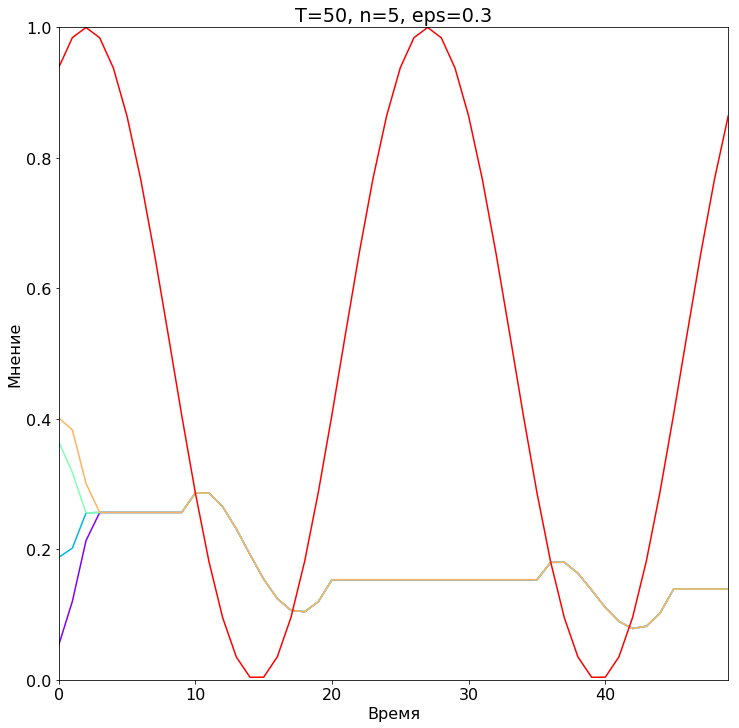

In [210]:
import random
matrix = dinamic_model(np.sort(np.random.sample(5)), random.choice(range(5)), 0.2, 100, 25)
plot_dinamic_model(matrix, 0.3, 50)

In [259]:
def get_stats(n, m, eps, T, times, delta=10**(-5)):
    stats = pd.DataFrame()
    models = pd.Series([Authority_Model(n, m, eps, T) for i in range(times)])
    off_models = models.apply(lambda x: x.off_authority())
    stats['stop_time'] = models.apply(lambda x: x.stop_moment(delta=delta))
    stats['n_cluster'] = models.apply(lambda x: x.cluster_count(delta=delta))
    stats['swap'] = models.apply(lambda x: x.swapping())
    stats['keeps_range'] = models.apply(lambda x: x.keeps_range())
    stats['off_time'] = off_models.apply(lambda x: x.stop_moment())
    stats['off_cluster'] = off_models.apply(lambda x: x.cluster_count())
    ainds = list(models.apply(lambda x: x.authority_ind))
    inputs = list(models.apply(lambda x: x.model[0]))
    return stats, inputs, ainds

In [260]:
def get_stats_fix(inputs, ainds, eps, T, times, delta=10**(-5)):
    stats = pd.DataFrame()
    models = pd.Series([Model(inputs[i], ainds[i], eps, T) for i in range(times)])
    off_models = models.apply(lambda x: x.off_authority())
    stats['stop_time'] = models.apply(lambda x: x.stop_moment(delta=delta))
    stats['n_cluster'] = models.apply(lambda x: x.cluster_count(delta=delta))
    stats['swap'] = models.apply(lambda x: x.swapping())
    stats['keeps_range'] = models.apply(lambda x: x.keeps_range())
    stats['off_time'] = off_models.apply(lambda x: x.stop_moment())
    stats['off_cluster'] = off_models.apply(lambda x: x.cluster_count())
    ainds = list(models.apply(lambda x: x.authority_ind))
    inputs = list(models.apply(lambda x: x.model[0]))
    return stats

In [173]:
stats = get_stats(10, 1, 0.25, 100, 100)[0]

In [163]:
stats['n_cluster'].value_counts()

2    52
1    48
Name: n_cluster, dtype: int64

In [176]:
stats[['n_cluster', 'off_cluster']].apply(lambda x: x.value_counts()[1]).to_frame().T

,n_cluster,off_cluster
0,11,21


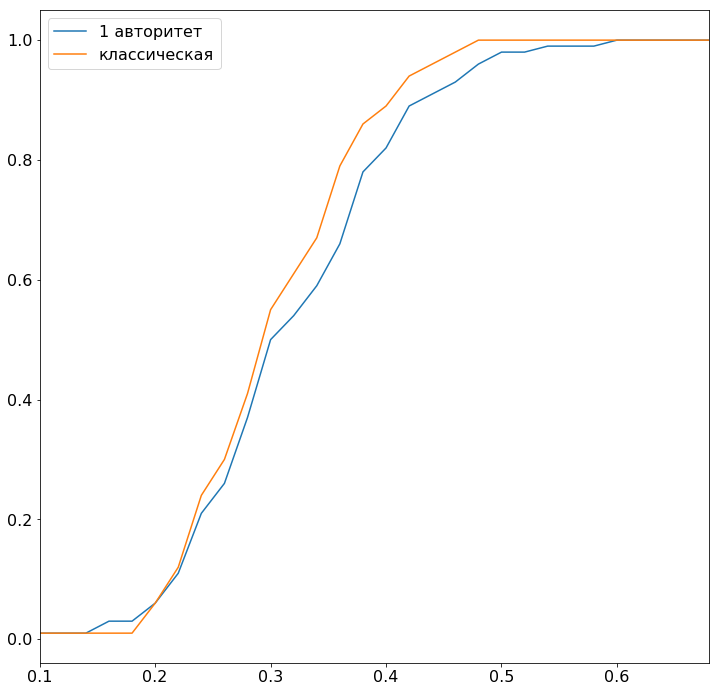

In [237]:
frame = pd.DataFrame()
stats, inputs, ainds = get_stats(10, 1, 0.1, 100, 100)
for i in np.arange(0.1, 0.7, 0.02):
    stats = get_stats_fix(inputs, ainds, round(i, 2), 100, 100)
    frame[round(i, 2)] = stats[['n_cluster', 'off_cluster']].apply(lambda x: x[x == 1].count())/100
frame.T.rename(columns={'n_cluster': '1 авторитет', 'off_cluster': 'классическая'}).plot(kind='line')

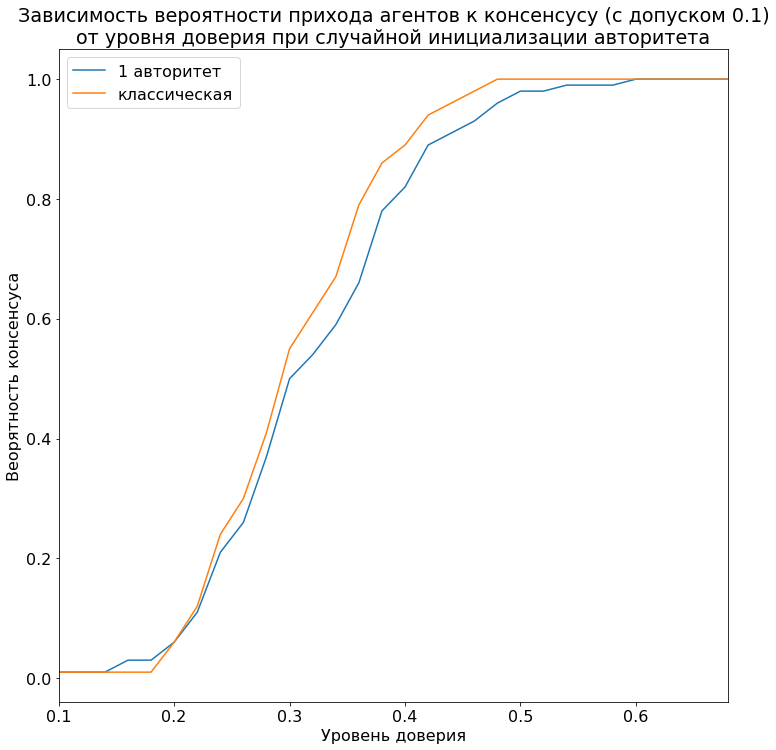

In [239]:
frame.T.rename(columns={'n_cluster': '1 авторитет', 'off_cluster': 'классическая'}).plot(kind='line', title='Зависимость вероятности прихода агентов к консенсусу (с допуском 0.1)\nот уровня доверия при случайной инициализации авторитета')
plt.xlabel('Уровень доверия')
plt.ylabel('Веорятность консенсуса')
plt.savefig('./Вероятность консенсуса (случайно) еще лучше.png')

In [271]:
fix = 4
delta = 10**(-1)
frame = pd.DataFrame()
stats, inputs, ainds = get_stats(10, 1, 0.1, 100, 100)
for i in np.arange(0.1, 0.7, 0.02):
    stats = get_stats_fix(inputs, [[fix]]*100, round(i, 2), 100, 100, delta=delta)
    frame[round(i, 2)] = stats[['n_cluster', 'off_cluster']].apply(lambda x: x[x == 1].count())/100

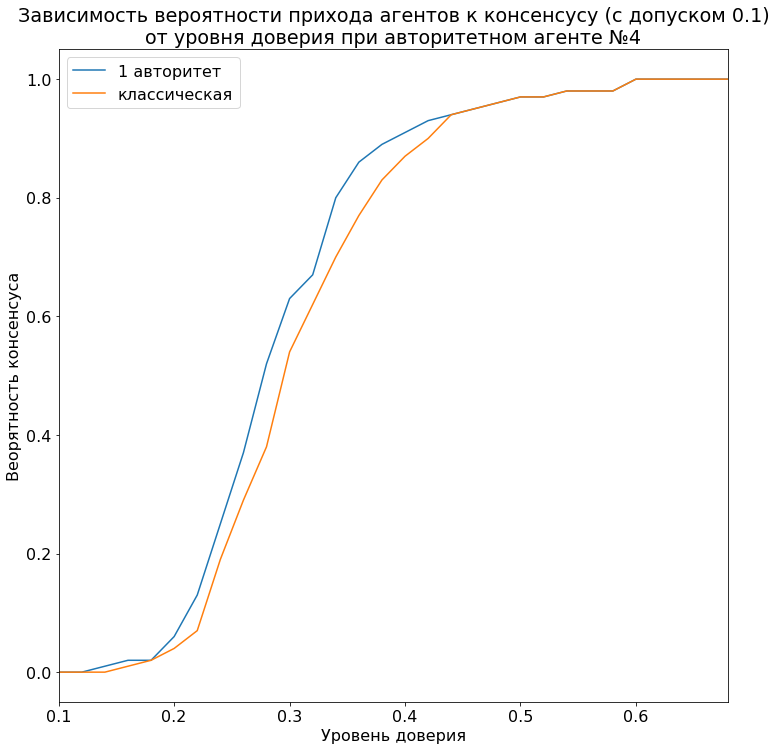

In [272]:
frame.T.rename(columns={'n_cluster': '1 авторитет', 'off_cluster': 'классическая'}).plot(kind='line', title=f'Зависимость вероятности прихода агентов к консенсусу (с допуском {delta})\nот уровня доверия при авторитетном агенте №{fix}')
plt.xlabel('Уровень доверия')
plt.ylabel('Веорятность консенсуса')
plt.savefig(f'./Вероятность консенсуса_{fix}_{delta}.png')

In [6]:
model = None
for i in range(500):
    model = Authority_Model(10, 1, 0.3, 100)
    if model.cluster_count() == 1:
        if model.off_authority().cluster_count() != 1:
            print('Success!')
            break

Success!


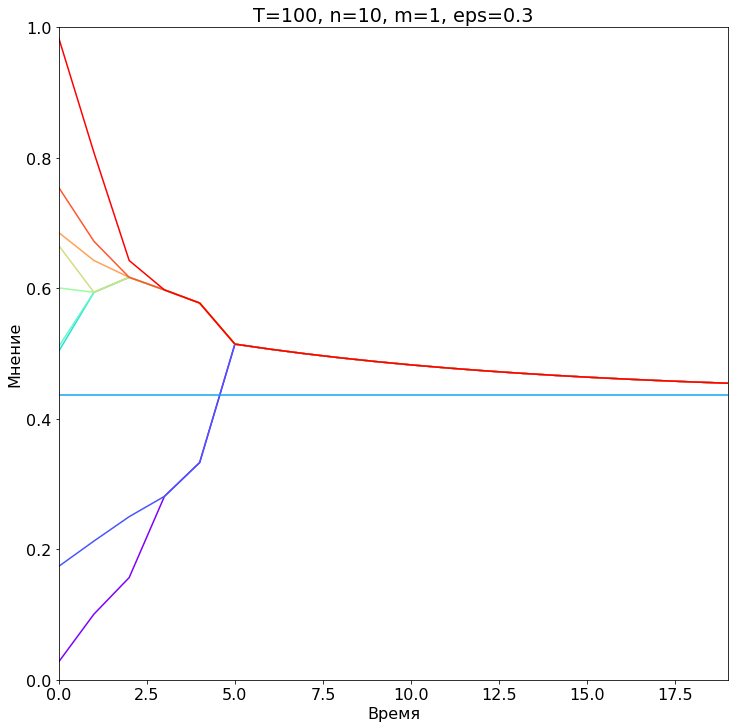

In [7]:
model.plot()

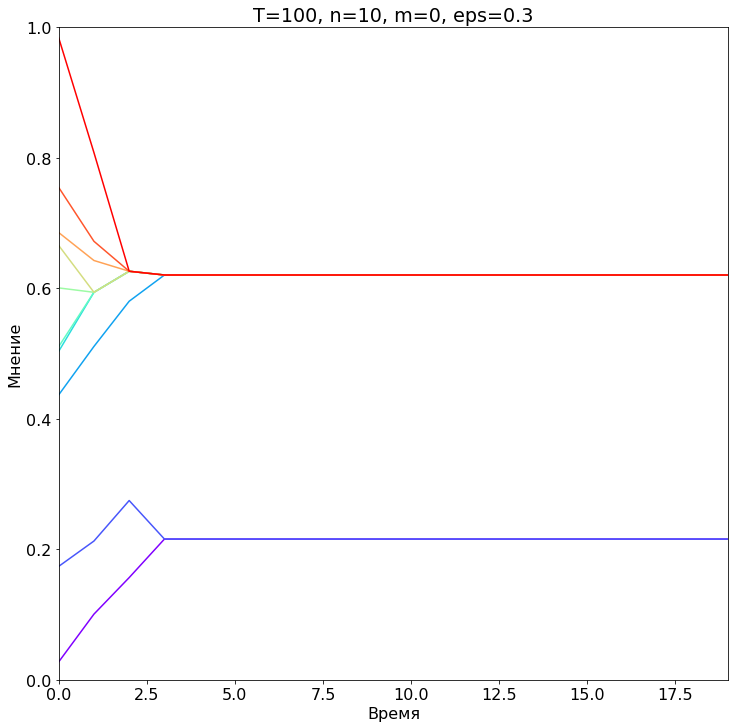

In [8]:
model.off_authority().plot()

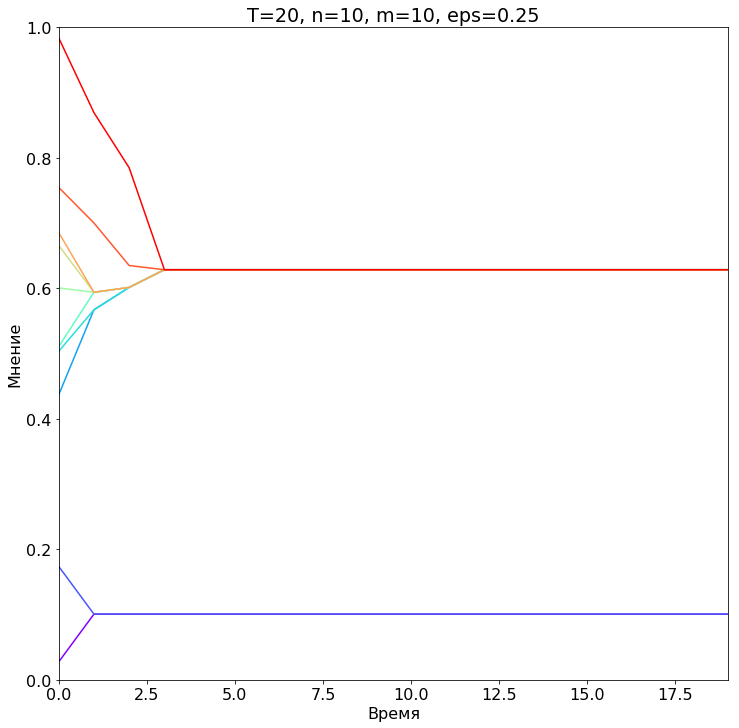

In [10]:
Model(model.model[0], list(range(10)), 0.25, 20).plot(path='./classic.png')

In [11]:
stats = get_stats(10, 2, 0.3, 100, 100)[0]

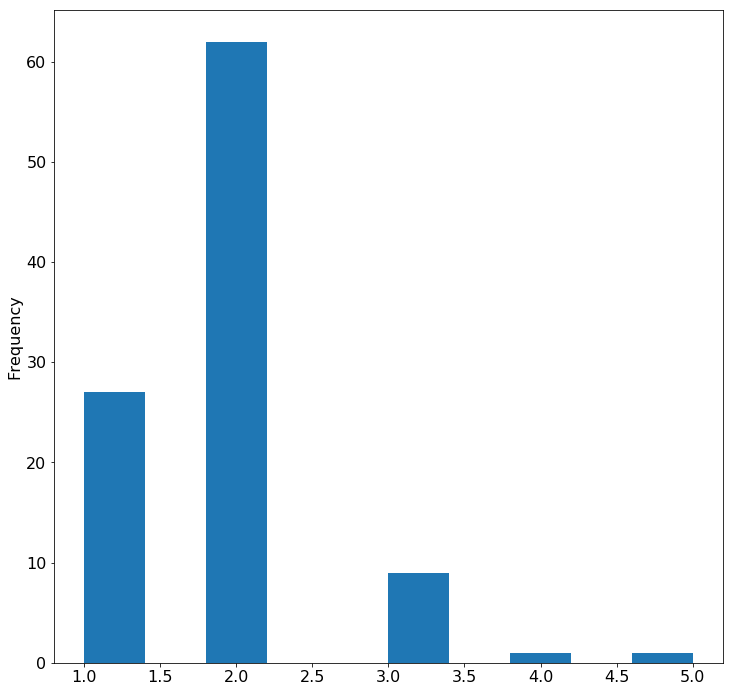

In [14]:
stats['n_cluster'].plot(kind='hist')

In [15]:
model = Authority_Model(10, 2, 0.3, 100)

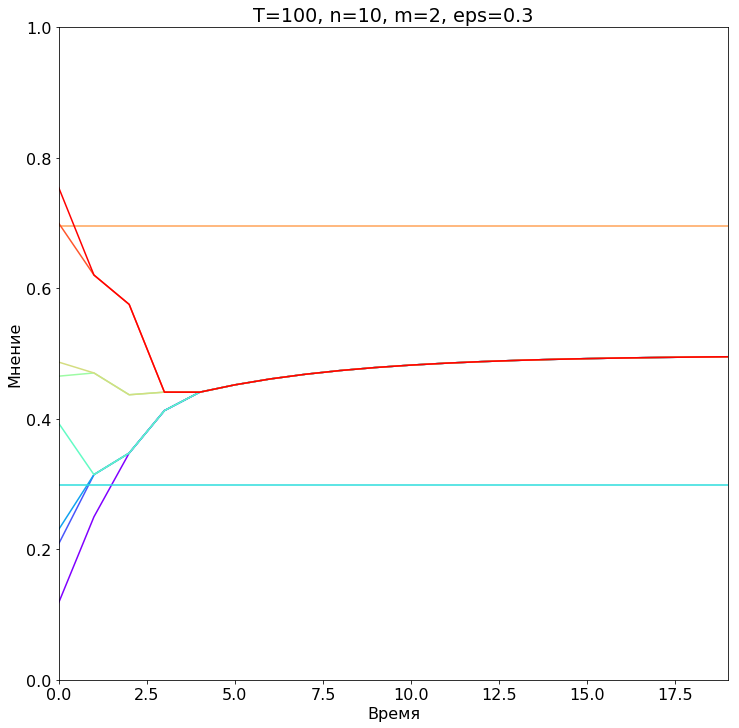

In [16]:
model.plot()

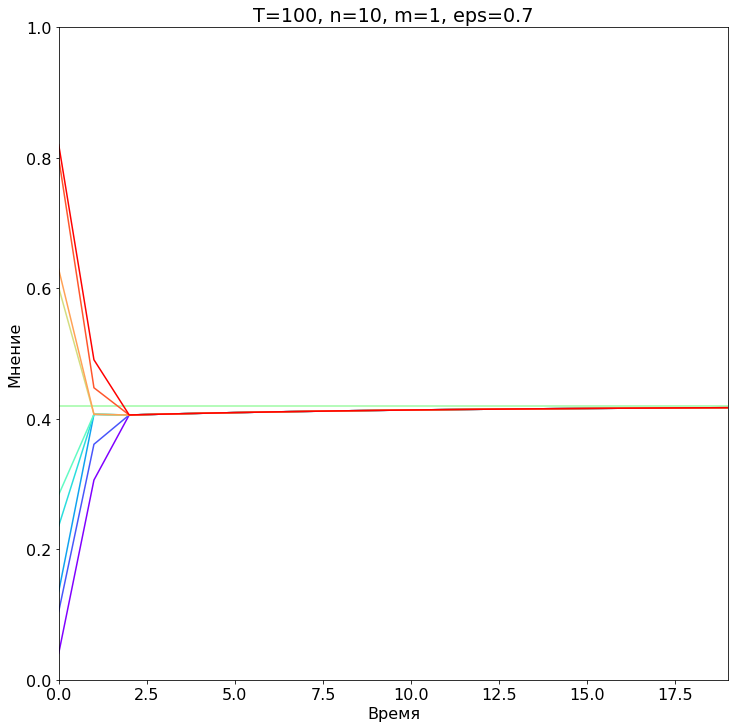

In [189]:
model = Authority_Model(10, 1, 0.7, 100)
model.plot()

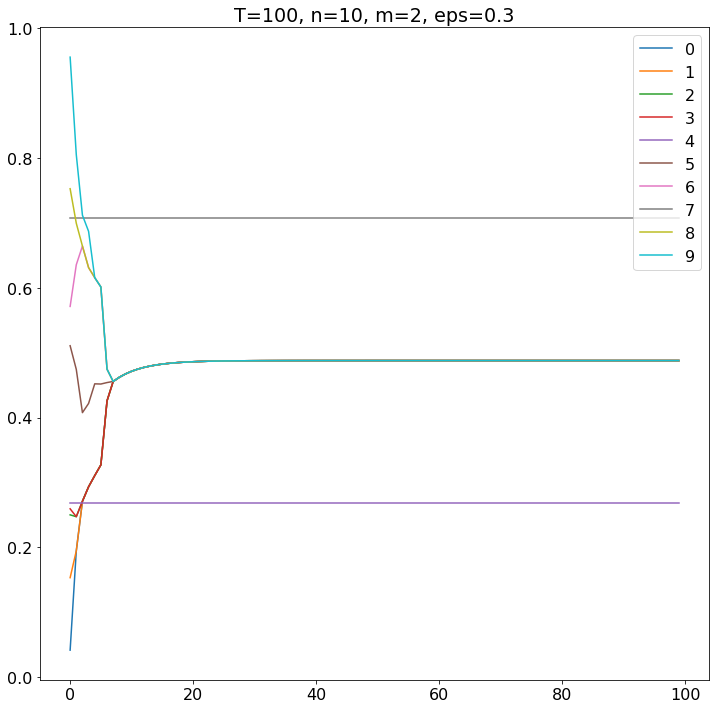

In [78]:
model.plot(path='./multiclass_03_100.png', T=100)

In [46]:
stop_time = {'min': {}, 'mean': {}, 'max': {}}
for i in range(1, 11):
    st, sw, kr, pars = get_pars(n, i, eps, T, times)
    stop_time['min'][i] = st.min()
    stop_time['mean'][i] = st.mean()
    stop_time['max'][i] = st.max()

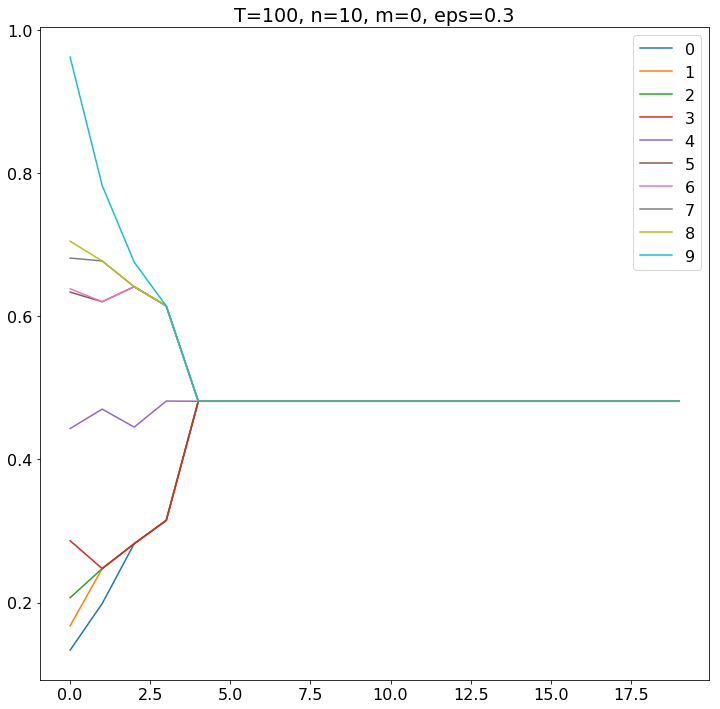

In [164]:
model = Authority_Model(10, 0, 0.3, 100)
model.plot()

In [104]:
model.init_from_x([0, 0.1, 0.2, 0.3], [], 0.100000000000001, 20)

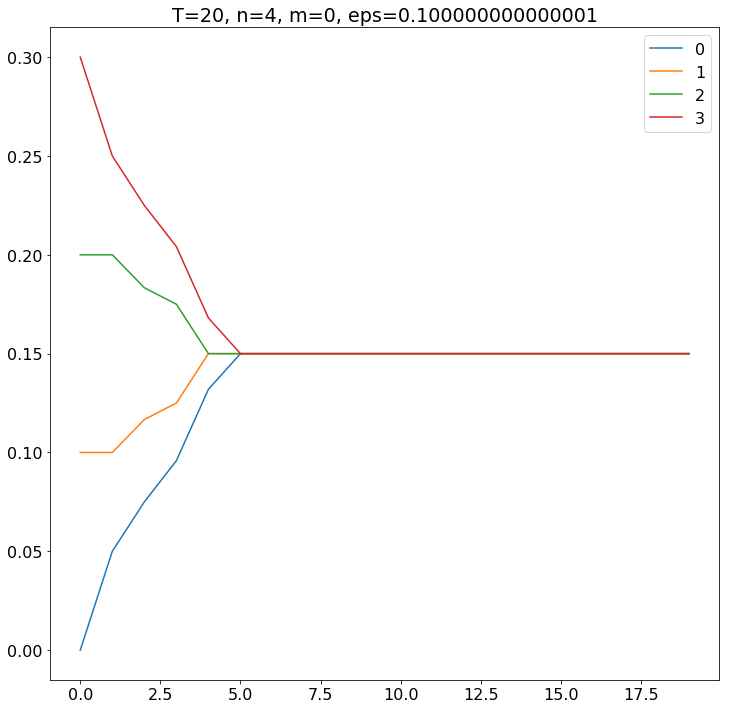

In [105]:
model.plot()

In [160]:
stop_moment(model.model)

42

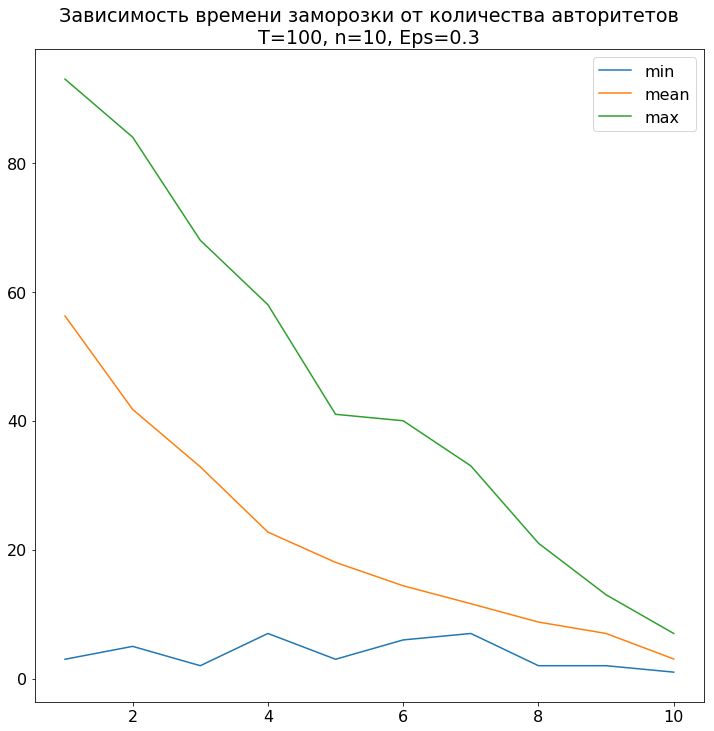

In [113]:
title ='Зависимость времени заморозки от количества авторитетов\nT='+str(T)+', n='+str(n)+', Eps='+str(eps)
pd.DataFrame(stop_time).plot(title=title)
plt.savefig(r'Зависимость времени заморозки от количества авторитетов.png')

In [140]:
n = 10
m = 6
eps= 0.3
T = 100
times = 100

stop_time = {'min': {}, 'mean': {}, 'max': {}}
for i in np.arange(0.1, 0.5, 0.05):
    st, sw, kr, pars = get_pars(n, m, i, T, times)
    stop_time['min'][i] = st.min()
    stop_time['mean'][i] = st.mean()
    stop_time['max'][i] = st.max()

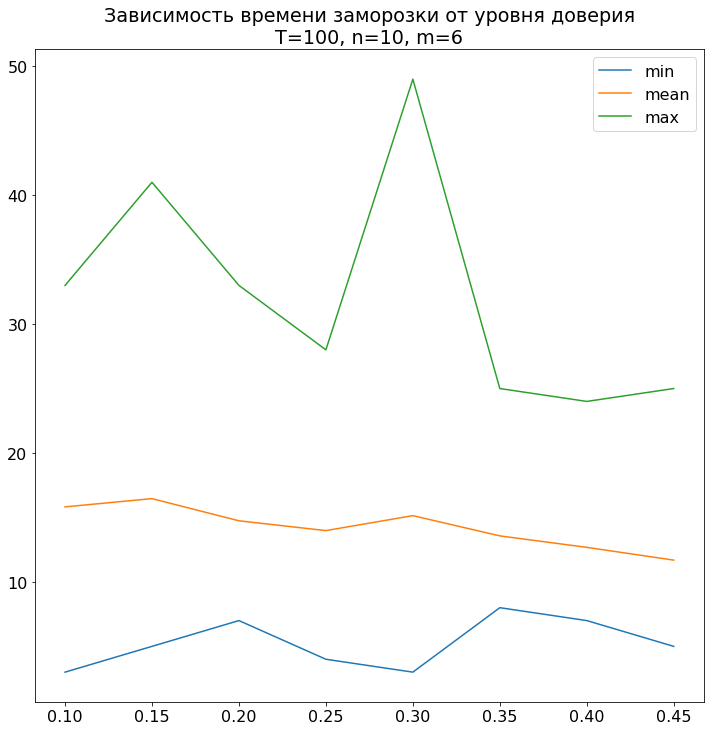

In [141]:
title ='Зависимость времени заморозки от уровня доверия\nT='+str(T)+', n='+str(n)+', m='+str(m)
pd.DataFrame(stop_time).plot(title=title)
plt.savefig(r'Зависимость времени заморозки от уровня доверия '+str(m)+'.png')

In [180]:
model.init_from_x(x, [ai], 0.3, 100)

In [9]:
model = None
for i in range(100):
    model = Authority_Model(10, 1, 0.25, 100)
    if model.cluster_count() == 1:
        if model.off_authority().cluster_count() != 1:
            print('Success!')
            break

Success!


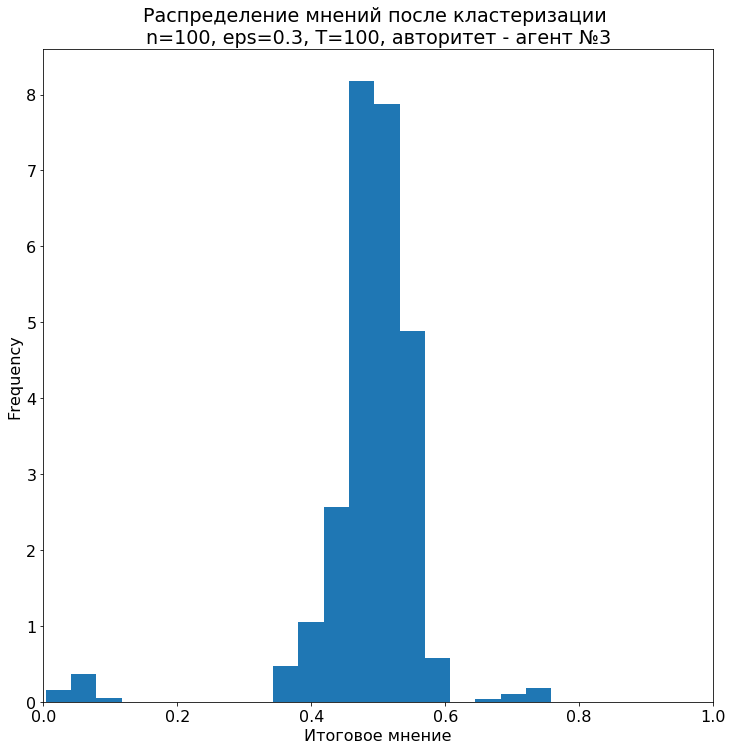

In [427]:
def claster_place_frec(n, eps, T, times, fix):
    stats_before, stats_after = [], []
    inits = []
    for i in range(times):
        model = Model(np.sort(np.random.sample(n)), [fix], eps, T)
        inits.append(model.model[0])
        stats_after += list(model.model[-1])
        stats_before += list(model.off_authority().model[-1])
    pd.Series(stats_after).plot(kind='hist', title=f'Распределение мнений после кластеризации \nn={n}, eps={eps}, T={T}, авторитет - агент №{fix}', **{'density': True, 'bins':20, 'xlim': (0, 1)})
    plt.xlabel('Итоговое мнение')
    return stats_after, stats_before, inits # теперь возвращает профили - то есть мы их запомнили
    
stats_after, stats_before, inits = claster_place_frec(100, 0.3, 100, 500, 3)
#lt.savefig(r'./Распределение мнений после кластеризации_0.3_3.png')

In [428]:
inits[0]

array([0.00422418, 0.01375567, 0.0148128 , 0.02187777, 0.03944875,
       0.04979321, 0.05605092, 0.05802369, 0.06325052, 0.07152937,
       0.07812987, 0.09766996, 0.10959055, 0.11990222, 0.14121473,
       0.15519783, 0.17150925, 0.17158386, 0.19123843, 0.19295888,
       0.22868609, 0.23544081, 0.25203088, 0.25483507, 0.26945172,
       0.27113317, 0.27169917, 0.27880737, 0.29461317, 0.2965019 ,
       0.29673899, 0.31513722, 0.31717349, 0.32408371, 0.35013422,
       0.35035355, 0.35506769, 0.37756939, 0.38248544, 0.38664643,
       0.39438804, 0.40617384, 0.41342753, 0.42858747, 0.4300174 ,
       0.43761825, 0.43991694, 0.44848589, 0.45080406, 0.47197793,
       0.49797289, 0.50248255, 0.50495292, 0.50518083, 0.51395614,
       0.51533706, 0.52692101, 0.5498486 , 0.55785291, 0.57374789,
       0.57734844, 0.58867926, 0.59213948, 0.60030618, 0.60486336,
       0.62065873, 0.64406345, 0.64530436, 0.65025314, 0.68943734,
       0.7008289 , 0.70990442, 0.72140794, 0.72936065, 0.75045

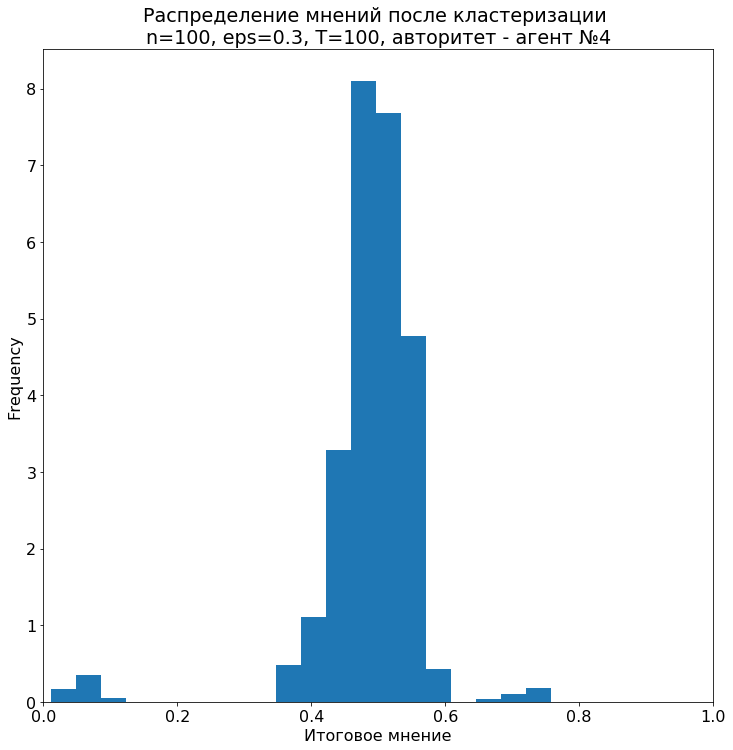

In [430]:
def claster_place_frec_fix(inits, eps, T, times, fix):
    stats_before, stats_after = [], []
    for i in range(times):
        model = Model(inits[i], [fix], eps, T)
        stats_after += list(model.model[-1])
        stats_before += list(model.off_authority().model[-1])
    pd.Series(stats_after).plot(kind='hist', title=f'Распределение мнений после кластеризации \nn={len(inits[0])}, eps={eps}, T={T}, авторитет - агент №{fix}', **{'density': True, 'bins':20, 'xlim': (0, 1)})
    plt.xlabel('Итоговое мнение')
    return stats_after, stats_before, inits # теперь возвращает профили - то есть мы их запомнили

stats_after, stats_before, inits = claster_place_frec_fix(inits, 0.3, 100, 500, 4)
#plt.savefig(r'./Распределение мнений после кластеризации_0.25_5.png')

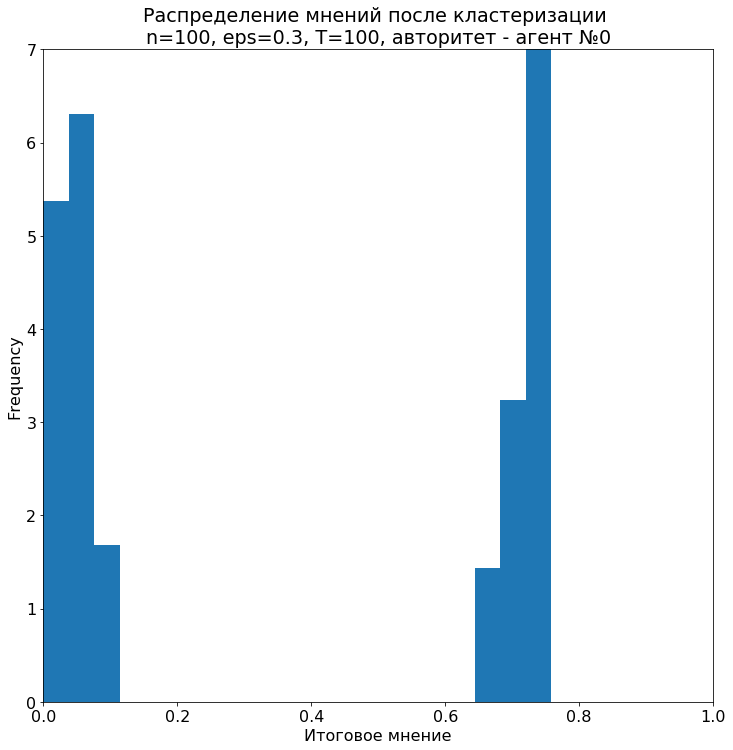

In [433]:
def claster_place_frec_fix(inits, eps, T, times, fix):
    stats_before, stats_after = [], []
    for i in range(times):
        model = Model(inits[i], [fix], eps, T)
        off_model = model.off_authority()
        if off_model.cluster_count() == 2:
            stats_after += list(model.model[-1])
            stats_before += list(off_model.model[-1])
    pd.Series(stats_after).plot(kind='hist', title=f'Распределение мнений после кластеризации \nn={len(inits[0])}, eps={eps}, T={T}, авторитет - агент №{fix}', **{'density': True, 'bins':20, 'xlim': (0, 1), 'ylim': (0, 7)})
    plt.xlabel('Итоговое мнение')
    return stats_after, stats_before, inits # теперь возвращает профили - то есть мы их запомнили

tn = 100
teps = 0.3
tT = 100

stats_after, stats_before, inits = claster_place_frec_fix(inits, teps, tT, 500, 0)
#plt.savefig(f'./pic2cl{teps}auth.png')

Text(0.5,0,'Итоговое мнение')

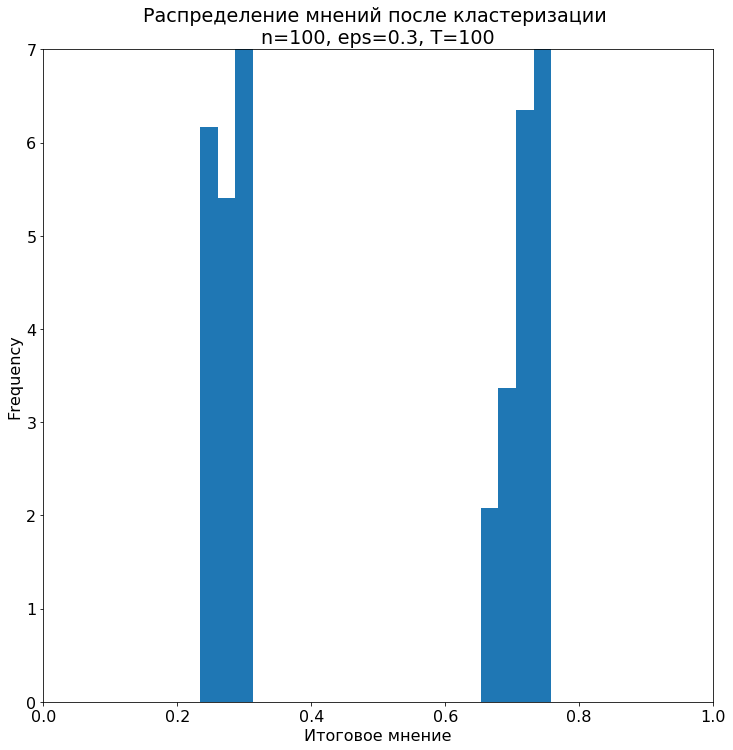

In [434]:
pd.Series(stats_before).plot(kind='hist', title=f'Распределение мнений после кластеризации \nn={tn}, eps={teps}, T={tT}', **{'density': True, 'bins':20, 'xlim': (0, 1), 'ylim': (0, 7)})
plt.xlabel('Итоговое мнение')
#plt.savefig(f'./pic2cl{teps}.png')

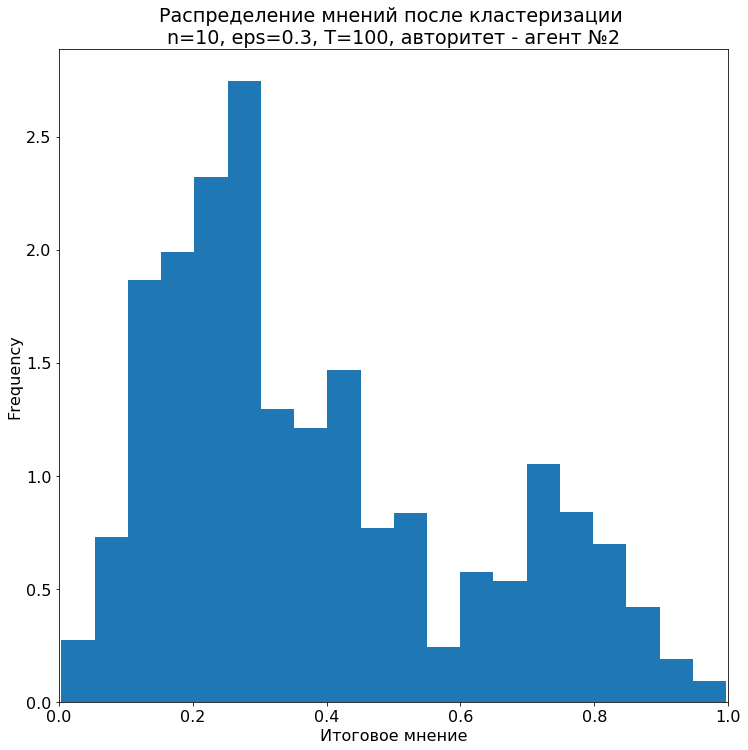

In [359]:
stats_after, stats_before, inits = claster_place_frec_fix(inits, 0.3, 100, 500, 2)

In [328]:
def effect(n, eps, T, times, fix, delta=10**(-1)):
    stats_after = []
    inits = []
    for i in range(times):
        model = Authority_Model(n, [fix], eps, T)
        inits.append(model.model[0])
        stats_after.append(len(np.where(model.model[-1] - model.model[-1, fix]  < delta)[0]))
    return sum(stats_after)/(times*n), inits

effect(10, 0.25, 100, 500, 4)

(0.794, [array([0.11964964, 0.21155773, 0.2838521 , 0.33307963, 0.40102839,
         0.57172416, 0.64215115, 0.70366554, 0.75442257, 0.86141401]),
  array([0.03623977, 0.10141282, 0.10808091, 0.23114173, 0.31143024,
         0.52619713, 0.63809075, 0.74191697, 0.75114917, 0.80828921]),
  array([0.11133171, 0.23551928, 0.24969445, 0.25804405, 0.2591296 ,
         0.40248842, 0.44987329, 0.74110993, 0.78785938, 0.87900836]),
  array([0.06380517, 0.14336644, 0.39245354, 0.48497251, 0.51858597,
         0.53415596, 0.71669151, 0.7305354 , 0.74765846, 0.82221265]),
  array([0.07798149, 0.11574714, 0.13060187, 0.17257121, 0.21191883,
         0.34204229, 0.59191129, 0.61372682, 0.62905266, 0.85916169]),
  array([0.01079361, 0.06759273, 0.08768591, 0.24062029, 0.42578157,
         0.56007654, 0.65479104, 0.76957623, 0.79759282, 0.79818876]),
  array([0.09491907, 0.12698212, 0.30814639, 0.31474243, 0.46185036,
         0.63908291, 0.8061273 , 0.81472042, 0.82747679, 0.83526857]),
  array([0.00

In [336]:
def effect_fix(inits, eps, T, times, fix, delta=10**(-1)):
    stats_after = []
    for i in range(times):
        model = Model(inits[i], [fix], eps, T)
        inits.append(model.model[0])
        stats_after.append(len(np.where(model.model[-1] - model.model[-1, fix]  < delta)[0]))
    return sum(stats_after)/(times*len(inits[0]))

In [345]:
def get_effect(n, T, times, delta=10**(-1)):
    eff, inits = effect(n, 0.1, T, times, 1)
    effects = pd.DataFrame()
    for fix in range(5):
        e = []
        for i in np.arange(0.1, 0.7, 0.02):
            e.append((round(i, 2), effect_fix(inits, round(i, 2), T, times, fix, delta)))
        effects[fix] = pd.Series(dict(e))
    return effects

effects = get_effect(10, 100, 100)

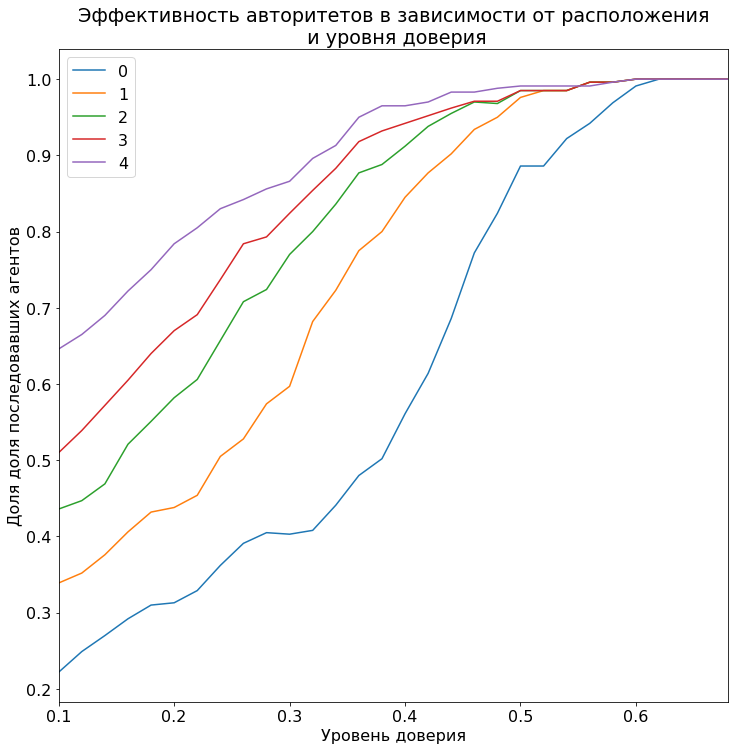

In [346]:
effects.plot(title='Эффективность авторитетов в зависимости от расположения\n и уровня доверия')
plt.xlabel('Уровень доверия')
plt.ylabel('Доля доля последовавших агентов')
plt.savefig('Эффективность.png')

Text(0.5,0,'Итоговое мнение')

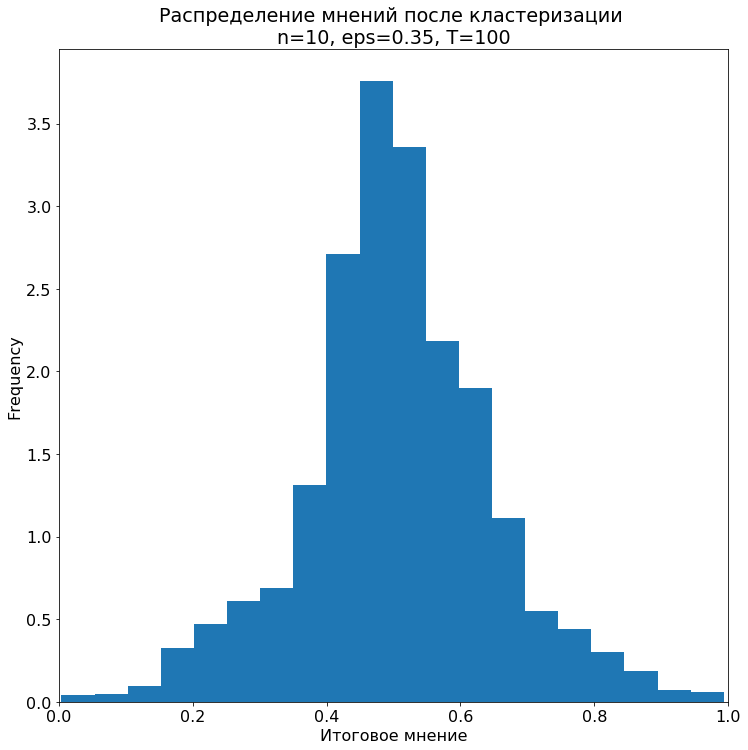

In [315]:
pd.Series(stats_before).plot(kind='hist',  **{'density': True, 'bins':20, 'xlim': (0, 1)}, title=f'Распределение мнений после кластеризации \nn=10, eps=0.35, T=100')
plt.xlabel('Итоговое мнение')
#plt.savefig(r'./Распределение мнений после кластеризации ba_0.35.png')

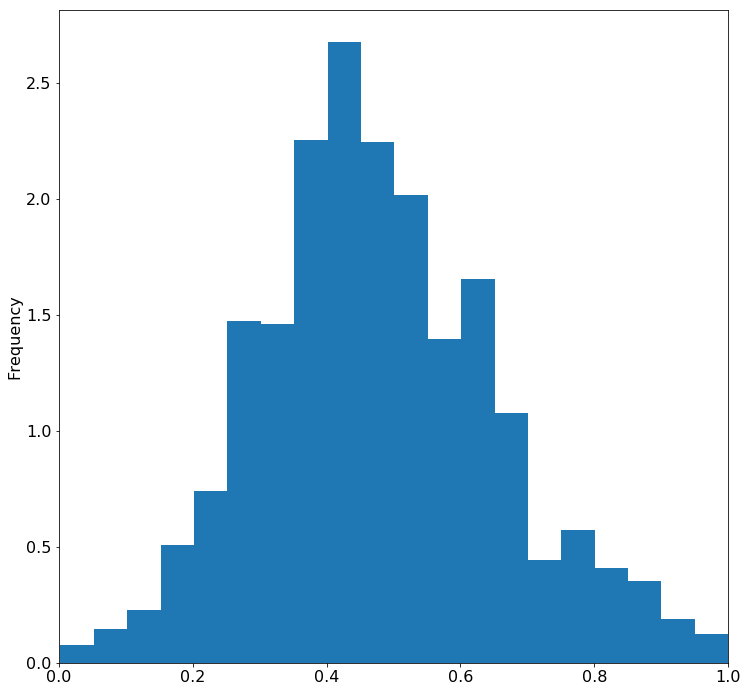

In [91]:
pd.Series(stats_after).plot(kind='hist', **{'density': True, 'bins':20, 'xlim': (0, 1)})

In [103]:
model = Authority_Model(10, 1, 0.3, 20)

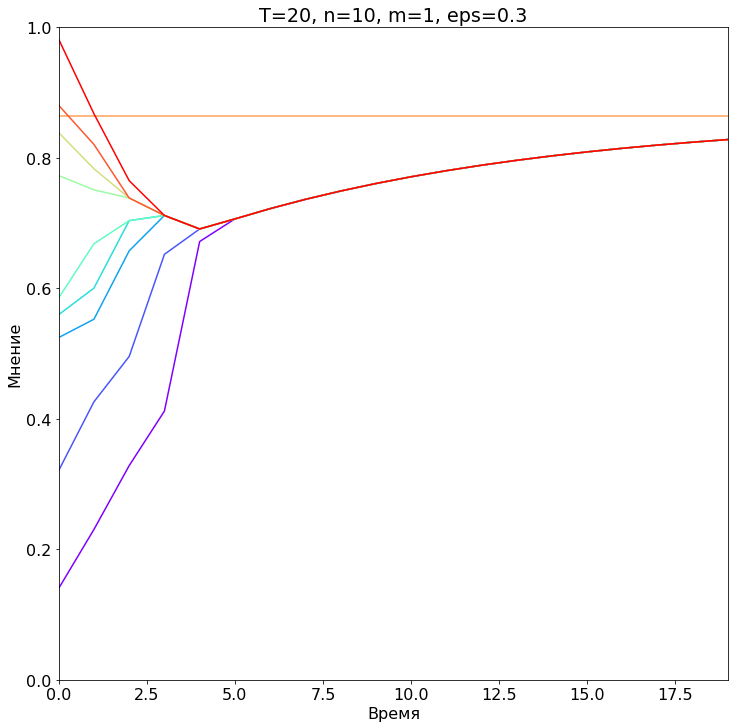

In [104]:
model.plot()

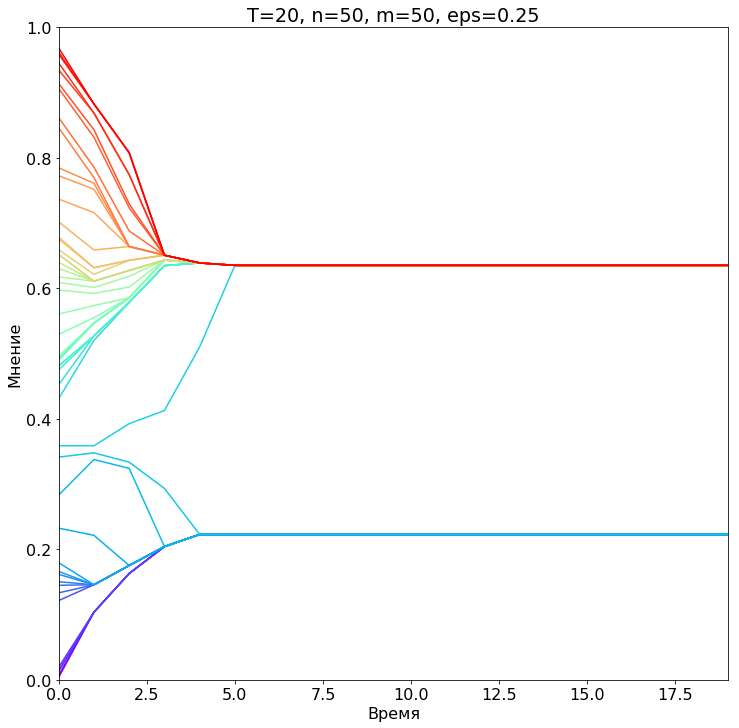

In [25]:
Model(model.model[0], list(range(50)), 0.25, 20).plot(path='./classic50.png')

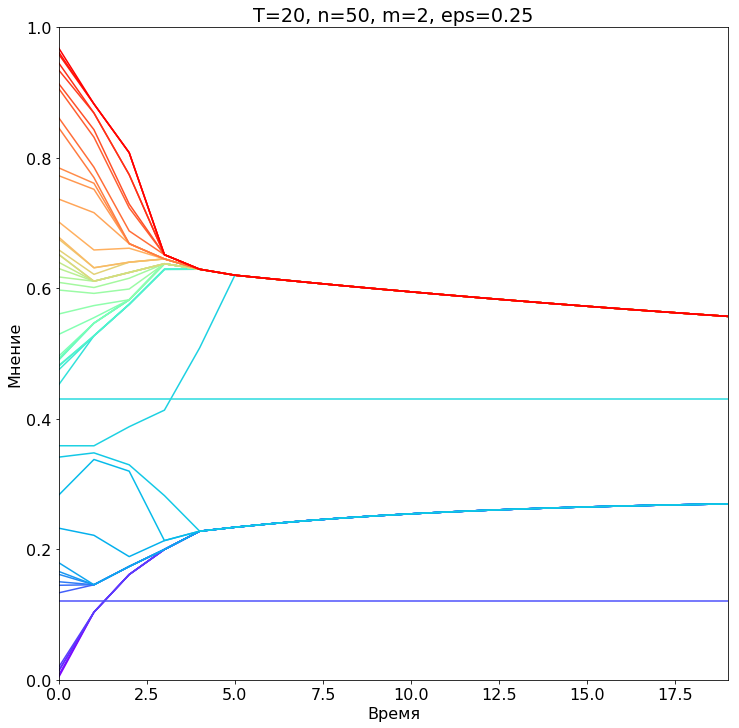

In [88]:
am = Model(model.model[0], np.random.choice(range(50), size=2), 0.25, 20)
am.plot()

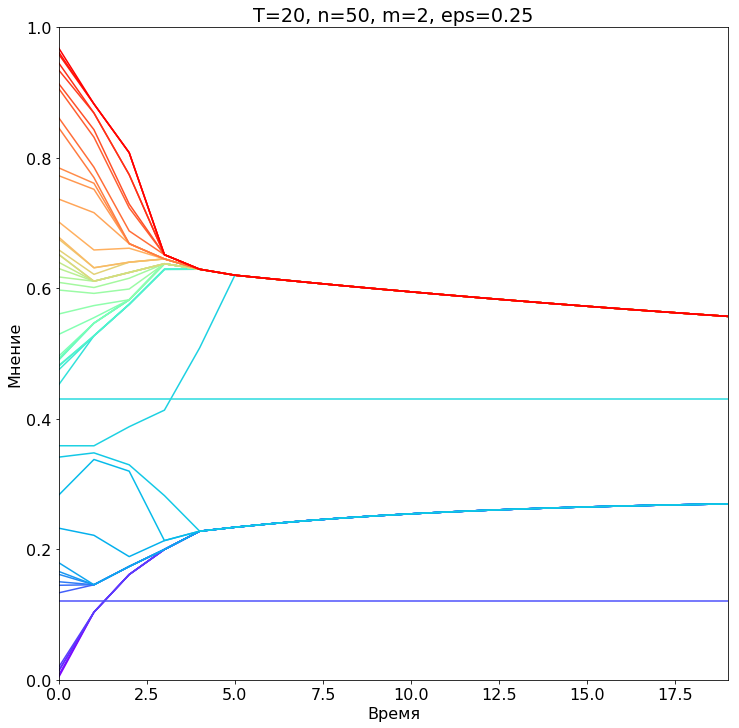

In [89]:
am.plot(path='./author2_4.png')

In [355]:
import pickle
with open('inits_dump.pkl', 'wb') as f:
    pickle.dump(inits, f)